In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv("./input/Constraint_English_Train - Sheet1.csv", index_col=0)
train.head()

,tweet,label
id,,
1,The CDC currently reports 99031 deaths. In gen...,real
2,States reported 1121 deaths a small rise from ...,real
3,Politically Correct Woman (Almost) Uses Pandem...,fake
4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
5,Populous states can generate large case counts...,real


In [3]:
val = pd.read_csv("./input/Constraint_English_Val - Sheet1.csv", index_col=0)
val.head()

,tweet,label
id,,
1,Chinese converting to Islam after realising th...,fake
2,11 out of 13 people (from the Diamond Princess...,fake
3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
4,Mike Pence in RNC speech praises Donald Trump’...,fake
5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [4]:
test = pd.read_csv("./input/Constraint_English_Test - Sheet1.csv", index_col=0)
test.head()

,tweet
id,
1,Our daily update is published. States reported...
2,Alfalfa is the only cure for COVID-19.
3,President Trump Asked What He Would Do If He W...
4,States reported 630 deaths. We are still seein...
5,This is the sixth time a global health emergen...


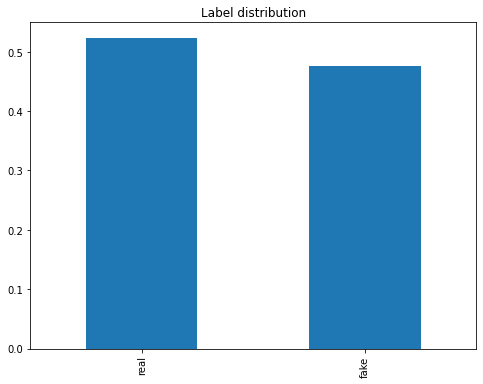

In [5]:
train["label"].value_counts(normalize=True).plot.bar()
plt.title("Label distribution")
plt.show()

In [6]:
print(train.tweet[1])

The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.


In [7]:
print(train.label[1])

real


In [8]:
train.label.value_counts()

real    3360
fake    3060
Name: label, dtype: int64

In [9]:
val.label.value_counts()

real    1120
fake    1020
Name: label, dtype: int64

In [10]:
data = pd.concat([train, val], ignore_index=True)
data.shape

(8560, 2)

In [11]:
data.label.value_counts()

real    4480
fake    4080
Name: label, dtype: int64

In [12]:
from preproc import process_text

In [13]:
data["tweet"].sample(10).apply(process_text)

6989    [world, health, organ, say, ’, zero, evid, har...
7971    [#hcp, today, 2pm, et, log, coca, facebook, pr...
5883    [indian, polic, personnel, beaten, person, enf...
5222    [fals, inform, #coronaviru, test, potenti, put...
74      [brazailian, parliament, went, hospit, take, c...
3741     [five, helicopt, spray, disinfect, german, citi]
2856    [anoth, reason, casual, attitud, peopl, toward...
4306    [pundit, say, trump, default, presid, need, st...
119     [#indiafightscorona, held, virtual, meet, toda...
7896    [arizona, california, florida, texa, still, ce...
Name: tweet, dtype: object

In [14]:
%%time
data["tweet_cleaned"] = data["tweet"].apply(lambda x: " ".join([i for i in process_text(x) if (i !='“' and i!="'" and i!='"' and i!='’')]))

CPU times: user 3.79 s, sys: 36.7 ms, total: 3.82 s
Wall time: 3.82 s


In [15]:
data.head()

,tweet,label,tweet_cleaned
0,The CDC currently reports 99031 deaths. In gen...,real,cdc current report 99031 death gener discrep d...
1,States reported 1121 deaths a small rise from ...,real,state report 1121 death small rise last tuesda...
2,Politically Correct Woman (Almost) Uses Pandem...,fake,polit correct woman almost use pandem excus re...
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real,#indiafightscorona 1524 #covid test laboratori...
4,Populous states can generate large case counts...,real,popul state gener larg case count look new cas...


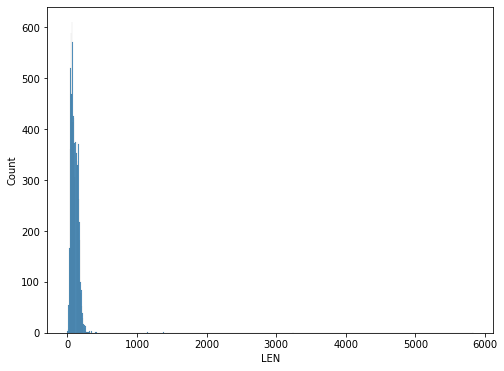

In [16]:
tmp = pd.DataFrame(data.tweet_cleaned.str.len().values, columns=["LEN"])
tmp.index.name = "ID"
tmp.reset_index(inplace=True)
sns.histplot(tmp, x="LEN")
plt.show()

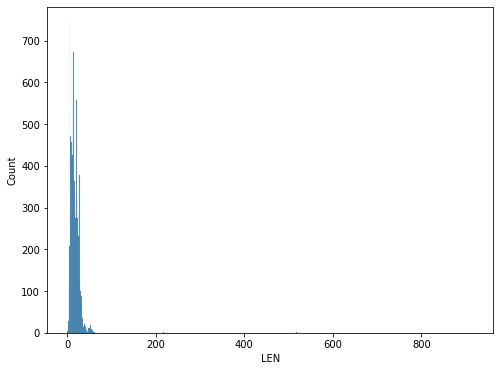

In [17]:
tmp = pd.DataFrame(data.tweet_cleaned.str.split().map(lambda x: len(x)).values, columns=["LEN"])
tmp.index.name = "ID"
tmp.reset_index(inplace=True)
sns.histplot(tmp, x="LEN")
plt.show()

In [18]:
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from collections import Counter

stop=set(stopwords.words('english'))

In [19]:
real_text = data[data.label=="real"]['tweet_cleaned'].str.split().values.tolist()
fake_text = data[data.label=="fake"]['tweet_cleaned'].str.split().values.tolist()

real_text = [word for line in real_text for word in line]
fake_text = [word for line in fake_text for word in line]

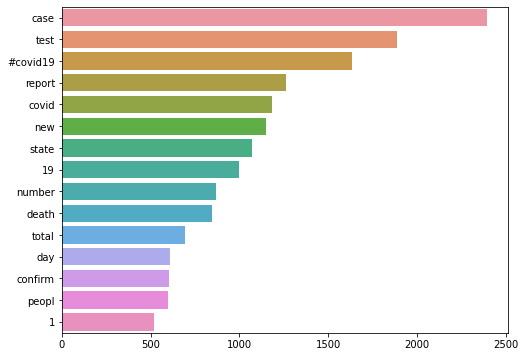

In [20]:
counter = Counter(real_text)

most = counter.most_common()

x, y = [], []

for word,count in most[:15]:
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x)
plt.show()

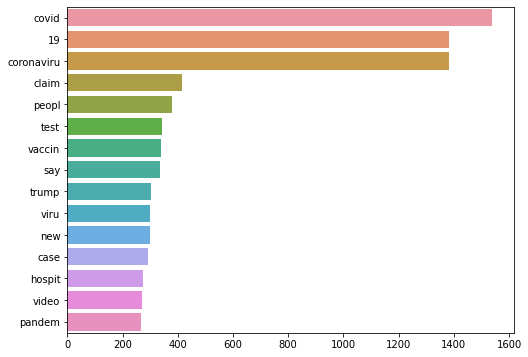

In [21]:
counter = Counter(fake_text)

most = counter.most_common()

x, y = [], []

for word,count in most[:15]:
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x)
plt.show()

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

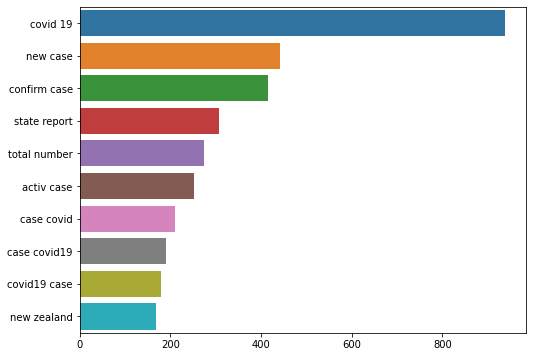

In [24]:
real_text = data[data.label=="real"]['tweet_cleaned']
top_n_bigrams=get_top_ngram(real_text, 2)[:15]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)
plt.show()

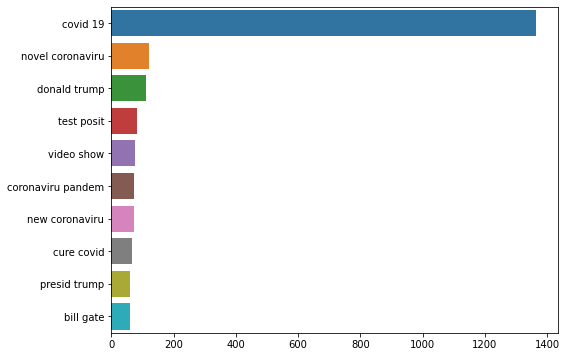

In [25]:
fake_text = data[data.label=="fake"]['tweet_cleaned']
top_n_bigrams=get_top_ngram(fake_text, 2)[:15]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)
plt.show()

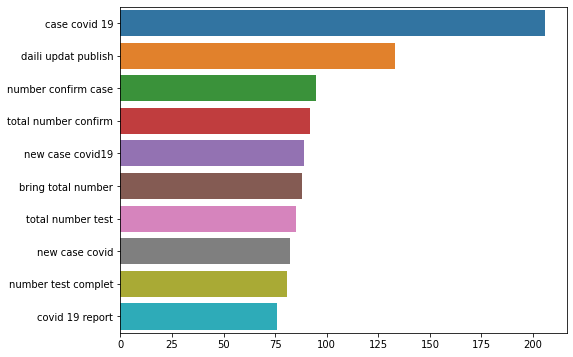

In [26]:
real_text = data[data.label=="real"]['tweet_cleaned']
top_n_bigrams=get_top_ngram(real_text, 3)[:15]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)
plt.show()

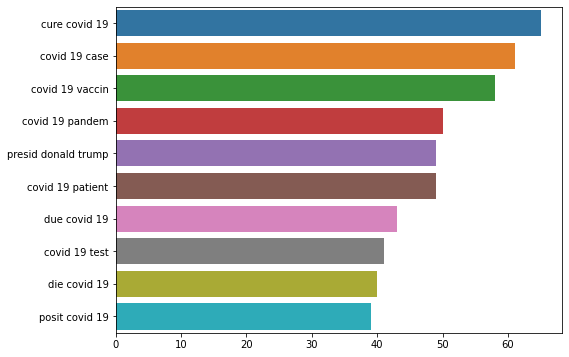

In [27]:
fake_text = data[data.label=="fake"]['tweet_cleaned']
top_n_bigrams=get_top_ngram(fake_text, 3)[:15]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)
plt.show()

In [28]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

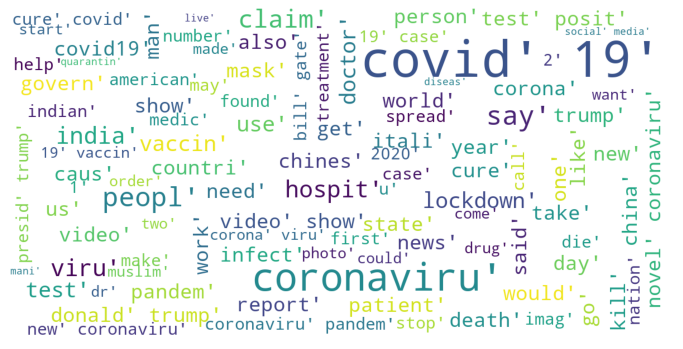

In [29]:
fake_text = data[data.label=="fake"]['tweet_cleaned'].str.split().values.tolist()

show_wordcloud(fake_text)

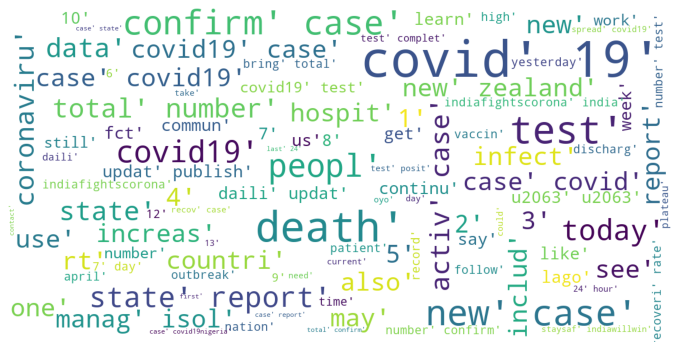

In [30]:
real_text = data[data.label=="real"]['tweet_cleaned'].str.split().values.tolist()

show_wordcloud(real_text)

In [31]:
data.sample(10)

,tweet,label,tweet_cleaned
933,"When we've eradicated Covid-19, can we get sta...",fake,we'v erad covid 19 get start moron get t-shirt
8343,States reported 1261 deaths and the 7-day aver...,real,state report 1261 death 7 day averag fell lowe...
2031,Medscape Poll: More than half of all providers...,real,medscap poll half provid never treat #covid pa...
339,We also found that death data made it more dif...,real,also found death data made difficult interpret...
3880,Boyacá scientist says he can cure patients wit...,fake,boyacá scientist say cure patient covid 19 biolog
3910,#IndiaFightsCorona Exponential Rise in Total T...,real,#indiafightscorona exponenti rise total test c...
1130,Here's the good news today: Deaths fell under ...,real,here' good news today death fell 400 first tim...
6453,RT @DDNewslive: Prime Minister @narendramodi t...,real,rt prime minist chair high level virtual meet ...
1966,Trump University Doing Research For Coronaviru...,fake,trump univers research coronaviru vaccin
2511,States reported ~23.5k new cases today. The 7-...,real,state report 23.5 k new case today 7 day avera...


In [32]:
data.tweet.str.split().apply(lambda x: len(x)).describe()

count    8560.00000
mean       26.94778
std        22.45087
min         3.00000
25%        15.00000
50%        25.00000
75%        37.00000
max      1456.00000
Name: tweet, dtype: float64

In [33]:
data["tweet_len"] = data.tweet.str.split().apply(lambda x: len(x))
data[data.tweet_len < 10].shape

(526, 4)